Work in Progress. Will be updated by Friday. Zheyu Ni

This file cleans the Airbnb data. 
1. deleted $ sign and comma in price.
2. visualize price distribution base on different features
3. Price range (0, 800) covers 95\% of the listings
4. create a dummy for the listing without review data
5. check how many listings have hotel/motel in name and agree with their room_type

The remaing data file contains \% of the raw data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import matplotlib.dates as mdates
from datetime import date
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

In [2]:
df = pd.read_csv('../listings_mar7_2023.csv')


In [3]:
#data cleaning. Price data has $ sign. The following code extracts the number
df['price'] = df['price'].replace({r'\$':''},regex = True).replace({r',':''},regex = True).astype('float')
df.price

0         399.0
1          46.0
2         408.0
3          80.0
4        2138.0
          ...  
42446      40.0
42447      48.0
42448      46.0
42449      68.0
42450      48.0
Name: price, Length: 42451, dtype: float64

In [4]:
print(df['room_type'].value_counts())

Entire home/apt    29491
Private room       12180
Shared room          697
Hotel room            83
Name: room_type, dtype: int64


In [5]:
df_practice = df.copy()
df_practice['name'] = df_practice['name'].str.lower()
df_practice.loc[df_practice['name'].str.contains('motel',regex=False) == True, 'room_type'] = 'Hotel room'
df_practice.loc[df_practice['name'].str.contains('hotel',regex=False) == True, 'room_type'] = 'Hotel room'
df['room_type'] = df_practice['room_type']
#df_practice.dropna()

In [6]:
print(df['room_type'].value_counts())

Entire home/apt    29293
Private room       12051
Shared room          696
Hotel room           411
Name: room_type, dtype: int64


In [7]:
df_practice.loc[df_practice['name'].str.contains('hotel',regex=False) == True].sample(2)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
2144,744929138353579650,https://www.airbnb.com/rooms/744929138353579650,20230307175359,2023-03-08,city scrape,la/beverly hills hotel style unit,LA Suites is nestled in the heart of Beverly H...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,484275960,...,NaN,NaN,NaN,NaN,t,55,55,0,0,NaN
31859,741343235157735784,https://www.airbnb.com/rooms/741343235157735784,20230307175359,2023-03-08,city scrape,charming double bed hotel style,LA Suites is nestled in the heart of Beverly H...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,484269516,...,NaN,NaN,NaN,NaN,t,60,60,0,0,NaN


In [8]:
df.head(2)

#columns that are interesting:
# latitude
# longitude
# room_type
# property_type
# accommodates
# bathrooms_text
# number_of_reviews
# first_review
# last_reviews
# reviews_per_month


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,777451666060243581,https://www.airbnb.com/rooms/777451666060243581,20230307175359,2023-03-07,city scrape,Family oriented home,Relax with the whole family at this peaceful p...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,490709958,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
1,698097753730921190,https://www.airbnb.com/rooms/698097753730921190,20230307175359,2023-03-07,city scrape,方便易居驿站,NaN,NaN,https://a0.muscache.com/pictures/d5afff58-d576...,444692513,...,5.0,5.0,4.4,NaN,f,4,0,4,0,0.86


In [9]:
#column_names =[df.columns,df.dtypes]
#list(column_names)

df.price[0:10]

0     399.0
1      46.0
2     408.0
3      80.0
4    2138.0
5      55.0
6      60.0
7      55.0
8     129.0
9     107.0
Name: price, dtype: float64

In [10]:
df.price.max()

99999.0

In [11]:
df = df[df['price'] < 1999]

In [12]:
df.price.max()

1995.0

In [13]:
df_priv = df[df['room_type']=='Private room'].copy()
df_homeapt = df[df['room_type']=='Entire home/apt'].copy()
df_share = df[df['room_type']=='Shared room'].copy()
df_hotel = df[df['room_type']=='Hotel room'].copy()

In [14]:
df_priv['latitude'].min()

33.33956

In [15]:
print(f"Range of latitude: {df_priv['latitude'].min()} to {df_priv['latitude'].max()}")
print(f"Range of longitude: {df_priv['longitude'].min()} to {df_priv['longitude'].max()}")

#https://www.usgs.gov/faqs/how-much-distance-does-a-degree-minute-and-second-cover-your-maps
#One degree of latitude equals approximately 364,000 feet (69 miles), one minute equals 6,068 feet (1.15 miles), and one-second equals 101 feet. 
ratio_miles_to_onelat = 69
desired_lat_mile_per_bin = 1 #i want each bin to represent x miles
diff_in_lats = df_priv['latitude'].max() - df_priv['latitude'].min()
diff_in_lats_in_miles = diff_in_lats*ratio_miles_to_onelat
bins_lats = int(np.round(diff_in_lats_in_miles/desired_lat_mile_per_bin))
print(f"Num of bins for latitude: {bins_lats}")


#One-degree of longitude equals 288,200 feet (54.6 miles), one minute equals 4,800 feet (0.91 mile), and one second equals 80 feet.
ratio_miles_to_onelong = 54.6
desired_long_mile_per_bin = 1 #i want each bin to represent x miles
diff_in_long = np.abs(df_priv['longitude'].max() - df_priv['longitude'].min())
diff_in_long_in_miles = diff_in_long*ratio_miles_to_onelong
bins_long = int(np.round(diff_in_long_in_miles/desired_long_mile_per_bin))
print(f"Num of bins for longitude: {bins_long}")



Range of latitude: 33.33956 to 34.81113
Range of longitude: -118.89972464431123 to -117.6534
Num of bins for latitude: 102
Num of bins for longitude: 68


In [16]:
#you have to add 1 to the bins because the very 1st element in the list is exclusive 
lats_bins_represent = np.linspace(df_priv['latitude'].min(),df_priv['latitude'].max(),bins_lats+1)
longs_bins_represent = np.linspace(df_priv['longitude'].min(),df_priv['longitude'].max(),bins_long+1)

# print(lats_bins_represent)
# print(longs_bins_represent)

In [17]:
H, xedges, yedges = np.histogram2d(df_priv['latitude'],df_priv['longitude'], bins=(bins_lats,bins_long) )

H = H.T

#if i do 0.1 mile per bin for both lats and longs, there is a bright yellow spot. It may so dense that it could be an outlier and over shadow it
#if you want to see, run the lines below multiple times to remove the outliers and run the histogram plotting cell

#I did a further analysis on exploring why their was an outlier
#there is one airbnb host that has multiple accounts and they have over 1500 listings
#they rent rooms in mansions I think. Seems absurd to have 1500 bedrooms available to rent all at one time
#https://www.airbnb.com/users/401130632/listings
#https://www.airbnb.com/users/144214204/listings
#I think I will definitely ignore them for this as this is a huge outlier
#http://insideairbnb.com/los-angeles
#      If you go here and scroll, you will see jino & scott own the most listings for private rooms
#
max_long_bin_num_priv = np.where(H == np.max(H))[0][0]
max_lat_bin_num_priv = np.where(H == np.max(H))[1][0]
print(H[max_long_bin_num_priv,max_lat_bin_num_priv])
H[max_long_bin_num_priv,max_lat_bin_num_priv] = 0 #when bins are represent 1 mile, do this to remove the outlier 

1781.0


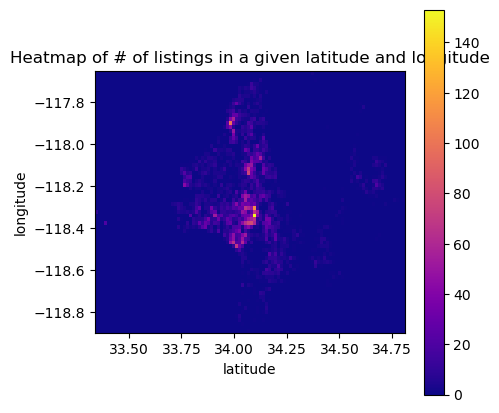

In [18]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(title='Heatmap of # of listings in a given latitude and longitude',
        aspect='equal')

X, Y = np.meshgrid(xedges, yedges)

hist2d = ax.pcolormesh(X, Y, H, cmap='plasma')
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
plt.colorbar(hist2d,ax=ax)
plt.show()

In [19]:
lats_bins_represent[max_lat_bin_num_priv],longs_bins_represent[max_long_bin_num_priv]

(34.161907941176466, -118.45984535808374)

In [20]:
def get_listings_in_bin(df, lat_bin_num, long_bin_num):
    cond_gt_lats = df['latitude'] > lats_bins_represent[lat_bin_num]
    cond_lt_lats = df['latitude'] <= lats_bins_represent[lat_bin_num+1]
    cond_gt_long = df['longitude'] > longs_bins_represent[long_bin_num]
    cond_lt_long = df['longitude'] <= longs_bins_represent[long_bin_num+1]
    cut_df = df[cond_lt_lats & cond_gt_lats & cond_lt_long & cond_gt_long].copy()
    return cut_df

In [21]:
outlier_df_priv = get_listings_in_bin(df_priv,max_lat_bin_num_priv,max_long_bin_num_priv)
outlier_df_priv.shape

(1781, 75)

In [22]:
min_max_scaled_H = H/np.max(H)

In [23]:
H.shape[1]

102

In [24]:
num_of_reviews_in_bin = np.zeros(H.shape)
for i in np.arange(0,H.shape[0],1):
    for j in np.arange(0,H.shape[1],1):
        dummy_df = get_listings_in_bin(df_priv,j,i)
        num_of_reviews_in_bin[i,j] = dummy_df['number_of_reviews'].sum()

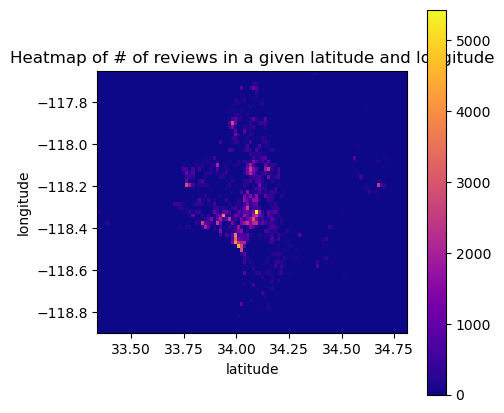

In [25]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(title='Heatmap of # of reviews in a given latitude and longitude',
        aspect='equal')

X, Y = np.meshgrid(xedges, yedges)

hist2d = ax.pcolormesh(X, Y, num_of_reviews_in_bin, cmap='plasma')
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
plt.colorbar(hist2d,ax=ax)
plt.show()

In [26]:
min_max_scaled_reviews = num_of_reviews_in_bin/np.max(num_of_reviews_in_bin)

In [27]:
num_of_reviews_per_month_in_bin = np.zeros(H.shape)
for i in np.arange(0,H.shape[0],1):
    for j in np.arange(0,H.shape[1],1):
        dummy_df = get_listings_in_bin(df_priv,j,i)
        num_of_reviews_per_month_in_bin[i,j] = dummy_df['reviews_per_month'].sum()

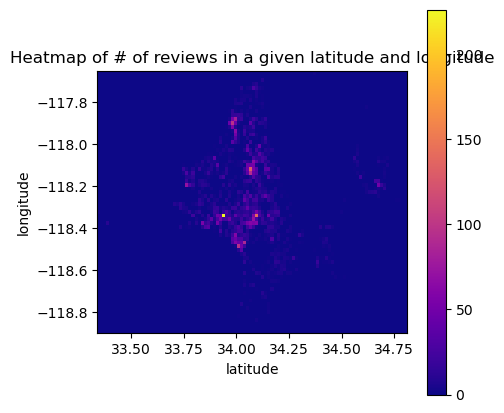

In [28]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(title='Heatmap of # of reviews in a given latitude and longitude',
        aspect='equal')

X, Y = np.meshgrid(xedges, yedges)

hist2d = ax.pcolormesh(X, Y, num_of_reviews_per_month_in_bin, cmap='plasma')
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
plt.colorbar(hist2d,ax=ax)
plt.show()

In [29]:
min_max_scaled_reviews_per_month = num_of_reviews_per_month_in_bin/np.max(num_of_reviews_per_month_in_bin)

In [30]:
#this here is the amount of areas where the # of listings scale was larger than the # of reviews
#so whatever number is outputed it is saying that there are x amount of bin regions where their are more listings in the region than there are reviews
np.shape(np.where((min_max_scaled_H - min_max_scaled_reviews) > 0.3))[1]

3

In [31]:
#this here is the amount of areas where the # of listings scale was smaller than the # of reviews
#so whatever number is outputed it is saying that there are x amount of bin regions where their are more reviews in the region than there are listings.
np.shape(np.where((min_max_scaled_H - min_max_scaled_reviews) < -0.3))[1]

11

In [32]:
df_priv['hotspot_from_listings'] = 0
df_priv['hotspot_from_reviews'] = 0
df_priv['hotspot_from_reviews_per_month'] = 0


In [33]:
for longs in np.arange(0,H.shape[0],1):
    for lats in np.arange(0,H.shape[1],1):
        cond_gt_lats = df_priv['latitude'] > lats_bins_represent[lats]
        cond_lt_lats = df_priv['latitude'] <= lats_bins_represent[lats+1]
        cond_gt_long = df_priv['longitude'] > longs_bins_represent[longs]
        cond_lt_long = df_priv['longitude'] <= longs_bins_represent[longs+1]
        df_priv.loc[cond_lt_lats & cond_gt_lats & cond_lt_long & cond_gt_long, 'hotspot_from_listings'] = min_max_scaled_H[longs,lats]
        df_priv.loc[cond_lt_lats & cond_gt_lats & cond_lt_long & cond_gt_long, 'hotspot_from_reviews'] = min_max_scaled_reviews[longs,lats]
        df_priv.loc[cond_lt_lats & cond_gt_lats & cond_lt_long & cond_gt_long, 'hotspot_from_reviews_per_month'] = min_max_scaled_reviews_per_month[longs,lats]


In [34]:
df_priv['category_hotness_from_listings'] = round(df_priv['hotspot_from_listings'],1)*10
df_priv['category_hotness_from_reviews'] = round(df_priv['hotspot_from_reviews'],1)*10
df_priv['category_hotness_from_reviews_per_month'] = round(df_priv['hotspot_from_reviews_per_month'],1)*10

In [35]:
df_priv[df_priv['hotspot_from_listings'] > 0.9].sample(2)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,hotspot_from_listings,hotspot_from_reviews,hotspot_from_reviews_per_month,category_hotness_from_listings,category_hotness_from_reviews,category_hotness_from_reviews_per_month
25478,11673505,https://www.airbnb.com/rooms/11673505,20230307175359,2023-03-08,previous scrape,Private Room & Bath near Sunset,"Spacious ""New"" building in the heart of Hollyw...",NaN,https://a0.muscache.com/pictures/709f95bb-e1a1...,29901714,...,0,1,0,0.01,1.0,0.45669,0.615255,10.0,5.0,6.0
11835,760172603230357402,https://www.airbnb.com/rooms/760172603230357402,20230307175359,2023-03-08,city scrape,Amazing private room/private bath in 2 bed 2 bath,"This special place is close to everything, mak...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,62778880,...,1,1,0,NaN,1.0,0.45669,0.615255,10.0,5.0,6.0


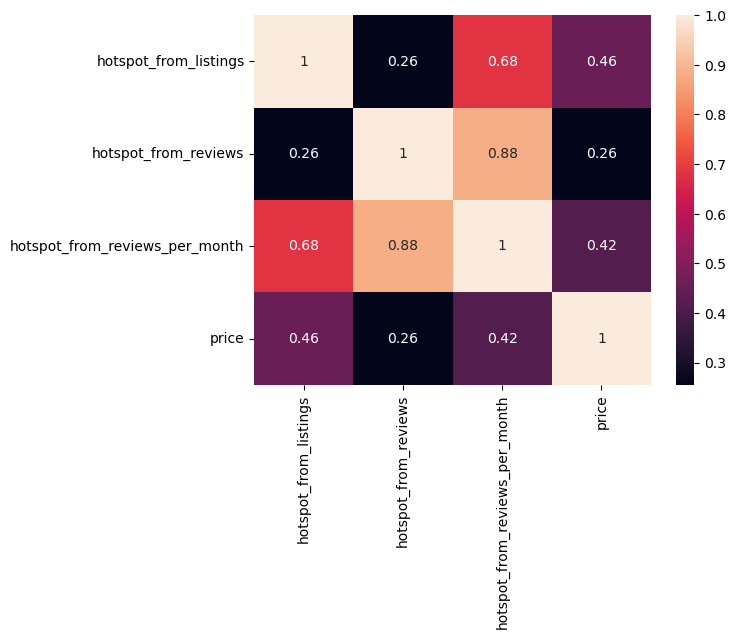

In [36]:
cut_priv = df_priv[(df_priv['hotspot_from_listings'] > 0.6) & (df_priv['accommodates'] < 6)].copy()
hotspot_corr = cut_priv[['hotspot_from_listings','hotspot_from_reviews','hotspot_from_reviews_per_month','price']].corr()
sns.heatmap(hotspot_corr, annot=True)
plt.show()

Text(0, 0.5, 'price per night')

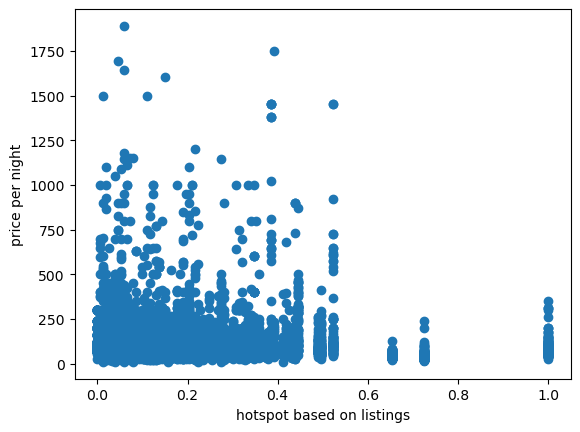

In [37]:
plt.scatter(df_priv['hotspot_from_listings'],df_priv['price'])
plt.xlabel('hotspot based on listings')
plt.ylabel('price per night')

In [38]:
df_priv[df_priv['price'] == df_priv['price'].max()]

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,hotspot_from_listings,hotspot_from_reviews,hotspot_from_reviews_per_month,category_hotness_from_listings,category_hotness_from_reviews,category_hotness_from_reviews_per_month
15624,31574513,https://www.airbnb.com/rooms/31574513,20230307175359,2023-03-08,city scrape,"Private Room by UNIVERSAL,WARNERBROS,DISNEY st...","We have a beautiful pool house, located in the...",Burbank is the heart of the entertainment indu...,https://a0.muscache.com/pictures/9beedbfe-5884...,31374204,...,6,12,0,0.04,0.058824,0.03944,0.06574,1.0,0.0,1.0


In [39]:
df_priv.price.max()

1890.0

In [40]:
df_priv[df_priv['accommodates'] == df_priv.accommodates.max()].sample(2)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,hotspot_from_listings,hotspot_from_reviews,hotspot_from_reviews_per_month,category_hotness_from_listings,category_hotness_from_reviews,category_hotness_from_reviews_per_month
3951,831627029021409949,https://www.airbnb.com/rooms/831627029021409949,20230307175359,2023-03-08,city scrape,505 - Private Space w/Female,You'll have a great time at this comfortable p...,NaN,https://a0.muscache.com/pictures/214463aa-6ae9...,179580368,...,10,1,0,NaN,0.339869,0.095835,0.059321,3.0,1.0,1.0
545,649939430496963824,https://www.airbnb.com/rooms/649939430496963824,20230307175359,2023-03-07,city scrape,"Prime Location! 4 Great Units, Pool, Restaurant",Feel refreshed and restored when you stay at t...,- Hermosa Beach Pier - 5.9 miles; <br />- Manh...,https://a0.muscache.com/pictures/prohost-api/H...,25138314,...,0,10,0,0.34,0.137255,0.181165,0.096950,1.0,2.0,1.0


In [41]:
df_priv.accommodates.max()

16

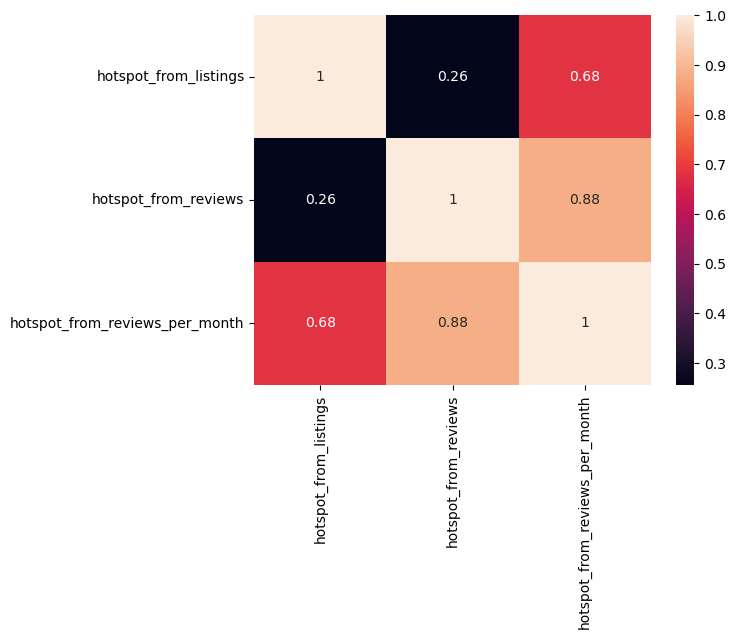

In [42]:
hotspot_corr = cut_priv[['hotspot_from_listings','hotspot_from_reviews','hotspot_from_reviews_per_month']].corr()
sns.heatmap(hotspot_corr, annot=True)
plt.show()

In [43]:
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils.np_utils import to_categorical

In [44]:
## we first make an empty model
## Sequential means we'll make a group
## of a linear stack of layers
model = models.Sequential()

In [45]:
###### ONLY RUN THIS ONCE! ##########

## you add a layer with .add()
## A Dense layer means a fully connected feedforward layer
## the 16 means the layer is 16 nodes tall
## activation='relu' means the layer uses a relu activation function
## the first layer needs to be told the shape of the input data
model.add(layers.Dense(16, activation = 'relu', input_shape=(2,)))

# we then add a second layer that is 16 nodes tall
# and uses the relu activation function
# note we don't need the input shape here, 
# it is inferred from the first layer's output
model.add(layers.Dense(16, activation = 'relu'))


# finally we add the output layer
# this will have a single node, representing a probability
# that the observation has positive sentiment
# this is why the activation is a softmax
# for more information on the softmax see the Practice Problems
model.add(layers.Dense(11, activation = 'softmax'))

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                48        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 11)                187       
                                                                 
Total params: 507
Trainable params: 507
Non-trainable params: 0
_________________________________________________________________


In [47]:
## we compile the network like so
## call .compile
## set our optimizer, optimizer='rmsprop'
## set our loss, loss='categorical_crossentropy'
## set our desired metrics, metrics=['accuracy']
model.compile(optimizer='rmsprop', 
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [48]:
X = df_priv[['latitude','longitude']]
y = df_priv['category_hotness_from_listings']

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                       test_size=.2,
                                                       shuffle=True,
                                                       random_state=124,
                                                       stratify=y)

In [49]:
X.shape

(11999, 2)

In [50]:
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train,
                                                                 test_size=.2,
                                                                   shuffle=True,
                                                                   random_state=41,
                                                                   stratify=y_train)

In [51]:
print(y_train_train)
print("\n\n\n")
print(to_categorical(y_train_train))
print(to_categorical(y_train_train).shape)
print(X_val.shape)

27808    2.0
9239     2.0
17647    2.0
12522    1.0
10425    2.0
        ... 
36106    2.0
28644    2.0
31593    1.0
15688    1.0
28248    0.0
Name: category_hotness_from_listings, Length: 7679, dtype: float64




[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
(7679, 11)
(1920, 2)


In [52]:
print(to_categorical(y_train_train).shape)
print(to_categorical(y_val).shape)
print(X_train_train.shape)
print(X_val.shape)

(7679, 11)
(1920, 11)
(7679, 2)
(1920, 2)


In [53]:
## I now fit the model, and store the training history
## I use 100 epochs and a batch_size of 512
n_epochs = 100
batch_size = 512

history = model.fit(X_train_train, to_categorical(y_train_train),
                       epochs = n_epochs,
                       batch_size = batch_size,
                       validation_data = (X_val, to_categorical(y_val)))

Epoch 1/100
15/15 [==============================] - 1s 15ms/step - loss: 6.4375 - accuracy: 0.0918 - val_loss: 3.9264 - val_accuracy: 0.1677
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 2.9009 - accuracy: 0.1567 - val_loss: 2.1682 - val_accuracy: 0.0672
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 1.9490 - accuracy: 0.1419 - val_loss: 1.7669 - val_accuracy: 0.1677
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 1.7065 - accuracy: 0.3123 - val_loss: 1.6630 - val_accuracy: 0.3370
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 1.6609 - accuracy: 0.3258 - val_loss: 1.6501 - val_accuracy: 0.3370
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 1.6564 - accuracy: 0.3316 - val_loss: 1.6570 - val_accuracy: 0.3370
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 1.6569 - accuracy: 0.3231 - val_loss: 1.6467 - val_accuracy: 0.3370
Epoch 8/100


In [54]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


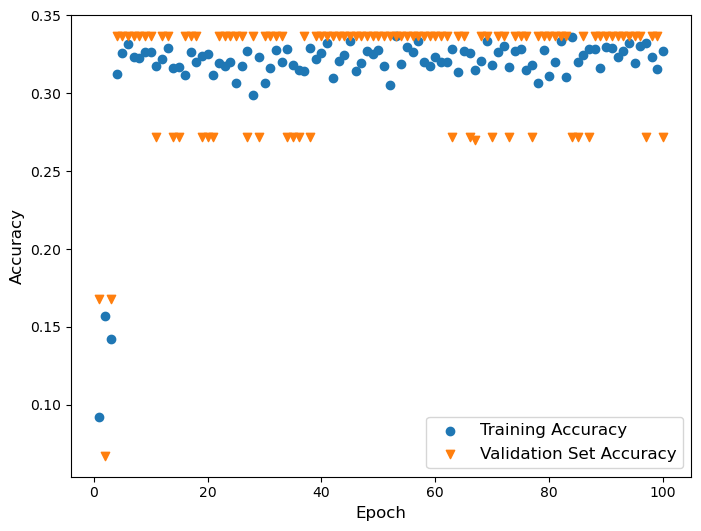

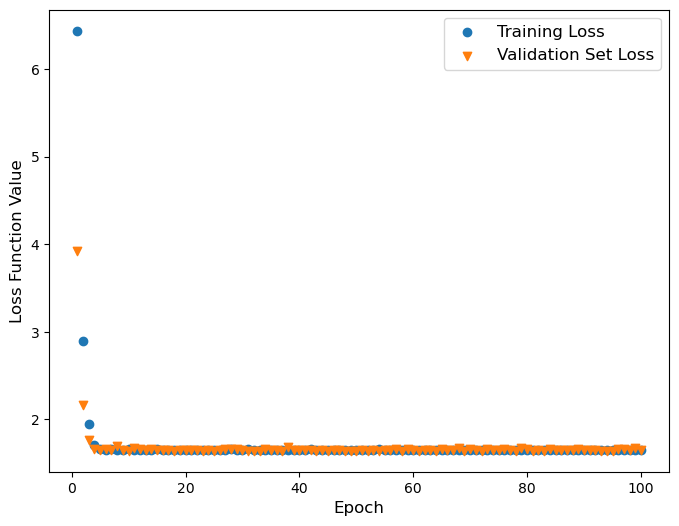

In [55]:
plt.figure(figsize = (8,6))

plt.scatter(range(1,n_epochs+1), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,n_epochs+1), history_dict['val_accuracy'], marker='v', label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()


plt.figure(figsize = (8,6))

plt.scatter(range(1,n_epochs+1), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,n_epochs+1), history_dict['val_loss'], marker='v', label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Function Value", fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=12)

plt.show()

In [56]:
## import the model
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [57]:
## this makes an mlp classifier with 1 hidden layer
## this layer has 500 nodes, controlled by hidden_layer_sizes
## we increase the maximum iterations for the gradient descent
mlp1 = MLPClassifier(hidden_layer_sizes=(500,), max_iter=5000)

## Here's a second classifier with 2 hidden layers of 200 nodes each,
## controlled by hidden_layer_sizes
## we increase the maximum iterations for the gradient descent
mlp2 = MLPClassifier(hidden_layer_sizes=(200, 200,), max_iter=5000)

In [58]:
mlp1.fit(X_train_train, y_train_train)
mlp2.fit(X_train_train, y_train_train)

MLPClassifier(hidden_layer_sizes=(200, 200), max_iter=5000)

In [59]:
print("The single hidden layer with 500 nodes has a training accuracy of",
         np.round(100*accuracy_score(y_train_train, mlp1.predict(X_train_train)),2))

print("The single hidden layer with 500 nodes has a validation accuracy of",
         np.round(100*accuracy_score(y_val, mlp1.predict(X_val)),2))

print("The two hidden layers with 200 nodes each has a training accuracy of",
         np.round(100*accuracy_score(y_train_train, mlp2.predict(X_train_train)),2))

print("The two hidden layers with 200 nodes each has a validation accuracy of",
         np.round(100*accuracy_score(y_val, mlp2.predict(X_val)),2))

The single hidden layer with 500 nodes has a training accuracy of 33.68
The single hidden layer with 500 nodes has a validation accuracy of 33.7
The two hidden layers with 200 nodes each has a training accuracy of 33.68
The two hidden layers with 200 nodes each has a validation accuracy of 33.7


In [60]:
print("Single hidden layer with 500 nodes\n",
     "+++++++++++++++++++++++++++++++++++++++++++++++++++++")
pd.DataFrame(confusion_matrix(y_val, mlp1.predict(X_val)), 
                columns=["predicted "+str(i) for i in range(8)],
                index=["actual "+str(i) for i in range(8)])



Single hidden layer with 500 nodes
 +++++++++++++++++++++++++++++++++++++++++++++++++++++


,predicted 0,predicted 1,predicted 2,predicted 3,predicted 4,predicted 5,predicted 6,predicted 7
actual 0,647,0,0,0,0,0,0,0
actual 1,522,0,0,0,0,0,0,0
actual 2,322,0,0,0,0,0,0,0
actual 3,205,0,0,0,0,0,0,0
actual 4,129,0,0,0,0,0,0,0
actual 5,37,0,0,0,0,0,0,0
actual 6,34,0,0,0,0,0,0,0
actual 7,24,0,0,0,0,0,0,0


In [61]:
print("Two hidden layers with 200 nodes each\n",
     "+++++++++++++++++++++++++++++++++++++++++++++++++++++")
pd.DataFrame(confusion_matrix(y_val, mlp2.predict(X_val)), 
                columns=["predicted "+str(i) for i in range(8)],
                index=["actual "+str(i) for i in range(8)])

Two hidden layers with 200 nodes each
 +++++++++++++++++++++++++++++++++++++++++++++++++++++


,predicted 0,predicted 1,predicted 2,predicted 3,predicted 4,predicted 5,predicted 6,predicted 7
actual 0,647,0,0,0,0,0,0,0
actual 1,522,0,0,0,0,0,0,0
actual 2,322,0,0,0,0,0,0,0
actual 3,205,0,0,0,0,0,0,0
actual 4,129,0,0,0,0,0,0,0
actual 5,37,0,0,0,0,0,0,0
actual 6,34,0,0,0,0,0,0,0
actual 7,24,0,0,0,0,0,0,0


In [62]:
#creates a map that has the shape of the united states

# fig = go.Figure(data=go.Scattergeo(
#         lon = df_priv['longitude'],
#         lat = df_priv['latitude'],
#         #text = 'Median house value: ' + housing['median_house_value'].astype(str),
#         #marker_size = (housing['bedrooms_per_household'])
#         ))
# fig.update_geos(fitbounds="locations")
# # fig.update_layout(
# #         title = 'Median house values of houses in California with marker size based on bedrooms per household',
# # )
# fig.show()

